# Data Preprocessing

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from utils.dataset import HerniaDataset

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import glob
import datetime
from bisect import bisect

%load_ext autoreload
%autoreload 2
print(torch.version.cuda)

None


In [2]:
video_base = 'data/videos'
videos = glob.glob(os.path.join(video_base, '*.mp4'))
videos

['data/videos/RALIHR_surgeon01_fps01_0071.mp4',
 'data/videos/RALIHR_surgeon01_fps01_0002.mp4',
 'data/videos/RALIHR_surgeon01_fps01_0001.mp4']

In [27]:
all_labels_df = pd.read_csv('data/labels/video.phase.trainingData.clean.StudentVersion.csv')
all_labels_name = pd.read_csv('data/labels/all_labels_hernia.csv', index_col='id')
labels_df = all_labels_df.loc[
    all_labels_df['videoName'].isin(
        list(map(lambda s: s.split('/')[-1].split('.')[0], videos))
    )
].copy()
# prepare labels
t0 = datetime.datetime(1900, 1, 1)
# convert end time to seconds
labels_df.loc[:, 'Seconds'] = labels_df['End'].apply(
    # convertor
    lambda x: (datetime.datetime.strptime(
        x, '%M:%S' if len(x.split(':')) == 2 else '%H:%M:%S'
    ) - t0).seconds
)
labels_df.loc[:, 'Durations'] = labels_df.loc[:, 'Seconds'].diff()
labels_df.loc[~(labels_df['Durations'] > 0), 'Durations'] = labels_df.loc[~(labels_df['Durations'] > 0), 'Seconds']
labels_df

,videoName,PhaseName,Start,End,Seconds,Durations
0,RALIHR_surgeon01_fps01_0001,stationary idle,00:00,00:16,16,16.0
1,RALIHR_surgeon01_fps01_0001,transitionary idle,00:16,00:35,35,19.0
2,RALIHR_surgeon01_fps01_0001,out of body,00:35,01:05,65,30.0
3,RALIHR_surgeon01_fps01_0001,transitionary idle,01:05,01:59,119,54.0
4,RALIHR_surgeon01_fps01_0001,peritoneal scoring,01:59,02:55,175,56.0
...,...,...,...,...,...,...
57,RALIHR_surgeon01_fps01_0002,positioning suture,47:02,47:38,2858,36.0
58,RALIHR_surgeon01_fps01_0002,peritoneal closure,47:38,51:19,3079,221.0
59,RALIHR_surgeon01_fps01_0002,positioning suture,51:19,52:37,3157,78.0
60,RALIHR_surgeon01_fps01_0002,transitionary idle,52:37,53:07,3187,30.0


## Dataset

In [17]:
trans = transforms.Compose([
    transforms.Resize((224, 224)), 
    #transforms.Normalize(mean=[0.485], std=[0.229])
])

In [38]:
dataset = HerniaDataset(videos[:2], labels_df, all_labels_name, trans)
dataset.cnts

[1321, 4519]

(<matplotlib.image.AxesImage at 0x7fb3db604f40>, 11)

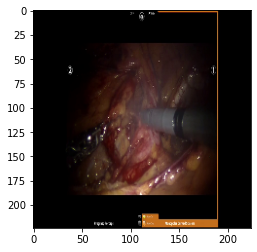

In [29]:
X, y = dataset[5000]
plt.imshow(X.permute(1, 2, 0)), y

## Weights

In [30]:
label_cnts = labels_df[['PhaseName', 'Durations']].groupby('PhaseName').sum()['Durations']
label_cnts

PhaseName
blurry                       55.0
catheter insertion           42.0
mesh placement              778.0
mesh positioning             56.0
out of body                 132.0
peritoneal closure          835.0
peritoneal scoring           84.0
positioning suture          389.0
preperioneal dissection     589.0
primary hernia repair       147.0
reduction of hernia        1267.0
stationary idle             296.0
transitionary idle          495.0
Name: Durations, dtype: float64

1.0

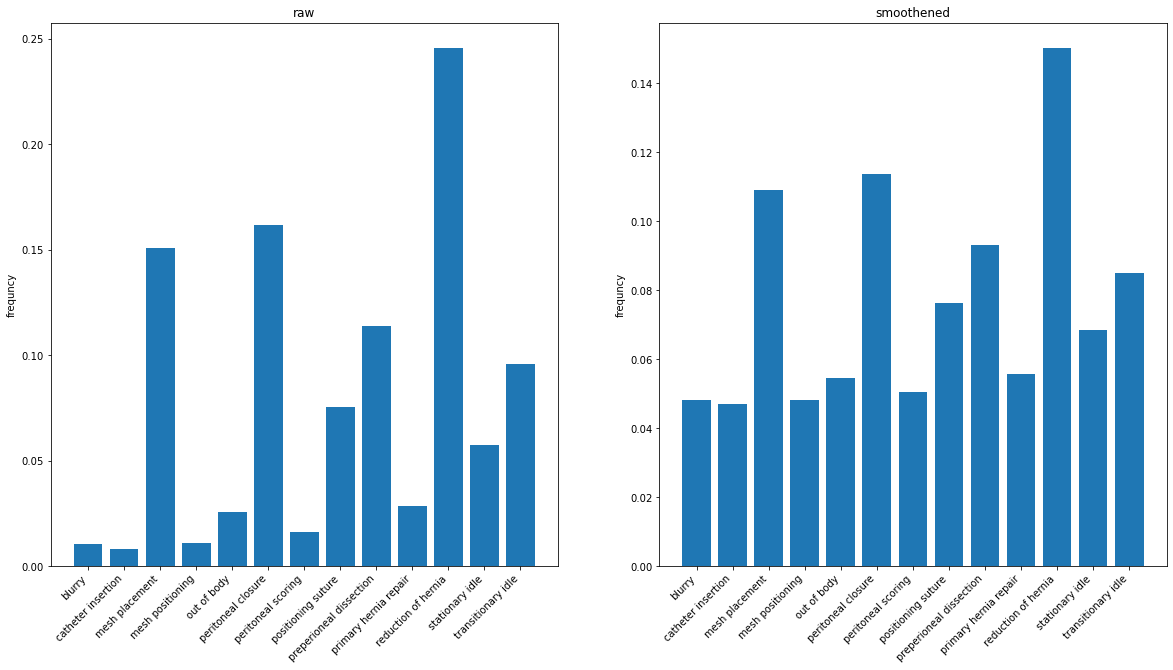

In [76]:
label_prob = label_cnts / label_cnts.sum()
# smoothing factor
a = 0.1
# laplace smoothing
class_weights = (label_prob + a) / (1 + a * len(label_prob))
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].bar(range(len(label_prob)), label_prob)
ax[0].set_xticks(range(len(label_prob)), label_prob.index.values, rotation=45, ha='right')
ax[0].set_ylabel('frequncy')
ax[0].set_title('raw')
ax[1].bar(range(len(class_weights)), class_weights)
ax[1].set_xticks(range(len(class_weights)), class_weights.index.values, rotation=45, ha='right')
ax[1].set_ylabel('frequncy')
ax[1].set_title('smoothened')
class_weights.sum()

In [47]:
labels_df.loc[:, 'SecondsAll'] = labels_df.loc[:, 'Durations'].cumsum()
labels_df

,videoName,PhaseName,Start,End,Seconds,Durations,SecondsAll
0,RALIHR_surgeon01_fps01_0001,stationary idle,00:00,00:16,16,16.0,16.0
1,RALIHR_surgeon01_fps01_0001,transitionary idle,00:16,00:35,35,19.0,35.0
2,RALIHR_surgeon01_fps01_0001,out of body,00:35,01:05,65,30.0,65.0
3,RALIHR_surgeon01_fps01_0001,transitionary idle,01:05,01:59,119,54.0,119.0
4,RALIHR_surgeon01_fps01_0001,peritoneal scoring,01:59,02:55,175,56.0,175.0
...,...,...,...,...,...,...,...
57,RALIHR_surgeon01_fps01_0002,positioning suture,47:02,47:38,2858,36.0,4825.0
58,RALIHR_surgeon01_fps01_0002,peritoneal closure,47:38,51:19,3079,221.0,5046.0
59,RALIHR_surgeon01_fps01_0002,positioning suture,51:19,52:37,3157,78.0,5124.0
60,RALIHR_surgeon01_fps01_0002,transitionary idle,52:37,53:07,3187,30.0,5154.0


In [59]:
all_labels_name.index[all_labels_name['labels'] == 'stationary idle'][0]

12

In [62]:
weights = [labels_df.loc[bisect(labels_df['SecondsAll'], i), 'PhaseName'] for i in range(len(dataset))]
weights = list(map(lambda x: all_labels_name.index[all_labels_name['labels'] == x][0], weights))

In [63]:
loader = DataLoader(dataset, 8, sampler=WeightedRandomSampler(weights, len(dataset), replacement=True))

tensor([ 6,  5,  8, 13,  9,  3,  3, 10])

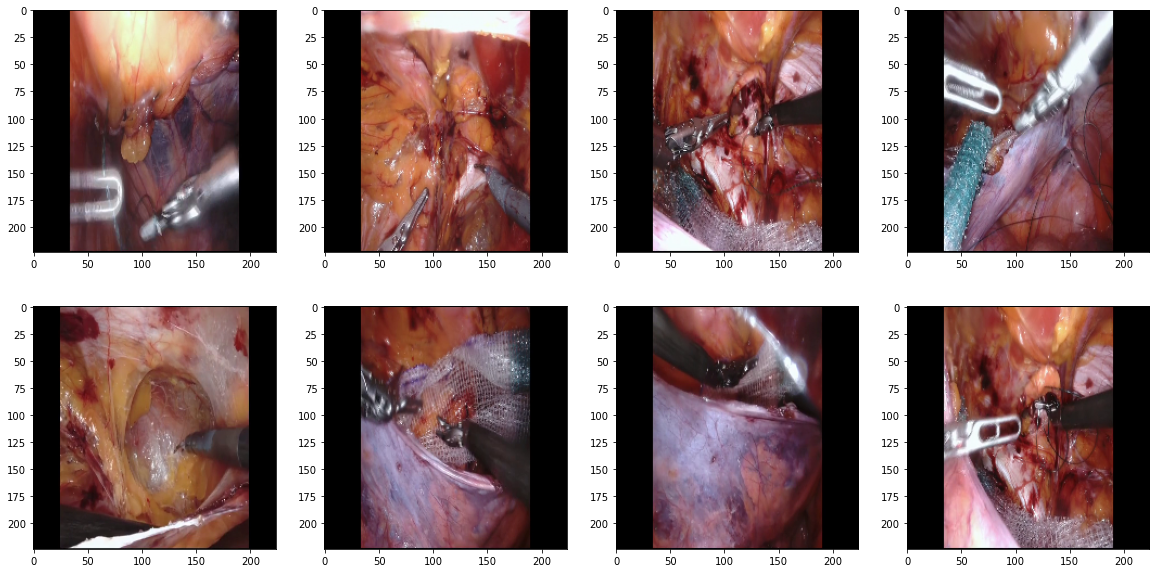

In [71]:
X, y = next(iter(loader))
_, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax[i // 4][i % 4].imshow(X[i].permute(1, 2, 0))
y